In [1]:
import torch
from torch.utils.data import DataLoader
from datasets import load_dataset
from transformers import AutoTokenizer

# Load the TinyStories dataset
dataset = load_dataset("roneneldan/TinyStories")
tokenizer = AutoTokenizer.from_pretrained("gpt2")  # or any suitable tokenizer
if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({'pad_token': '[PAD]'})
# Preprocess the dataset
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=512)

tokenized_datasets = dataset.map(tokenize_function, batched=True)
tokenized_datasets = tokenized_datasets.remove_columns(["text"])  # Remove original text, keep only tokens
tokenized_datasets.set_format("torch")  # Set format to PyTorch tensors

vocab_size=tokenizer.vocab_size+1
device="cuda" if torch.cuda.is_available() else "cpu"

/home/user/anaconda3/lib/python3.11/site-packages/huggingface_hub/repocard.py:105: UserWarning: Repo card metadata block was not found. Setting CardData to empty.
  warnings.warn("Repo card metadata block was not found. Setting CardData to empty.")


In [2]:
import math
from continous_diffusion.diffusion import Diffusion
from continous_diffusion.model import TransformerModel
from continous_diffusion.loss import Loss
from continous_diffusion.embedding import Embedder
from continous_diffusion.scheduling import CauchySchedule, LogisticSchedule
from continous_diffusion.conditioning import TimeConditioning

embed_dim=256
num_heads=8
cond_dim=16
n_blocks=2

dit=TransformerModel(embed_dim,num_heads,cond_dim,n_blocks)
embedder=Embedder(vocab_size,embed_dim)
schedule=CauchySchedule(0.01,200,0,0.3,math.log(vocab_size),0)
loss=Loss(embedder,schedule)
conditioning=TimeConditioning(cond_dim,cond_dim)
model=Diffusion(dit,loss,conditioning).to(device)

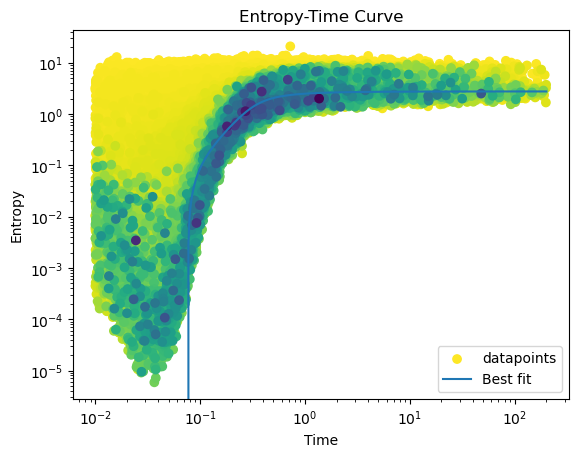

Step: 6000,  Loss: 1.1872098445892334
Step: 6001,  Loss: 1.4161944389343262
Step: 6002,  Loss: 1.1169618368148804
Step: 6003,  Loss: 0.9570285081863403
Step: 6004,  Loss: 1.0760555267333984
Step: 6005,  Loss: 1.2848843336105347
Step: 6006,  Loss: 1.2907512187957764
Step: 6007,  Loss: 1.275754690170288
Step: 6008,  Loss: 1.0308797359466553
Step: 6009,  Loss: 1.4385316371917725
Step: 6010,  Loss: 1.0401724576950073
Step: 6011,  Loss: 1.3393878936767578
Step: 6012,  Loss: 1.131690263748169
Step: 6013,  Loss: 1.2183302640914917
Step: 6014,  Loss: 1.1476061344146729
Step: 6015,  Loss: 1.062680721282959
Step: 6016,  Loss: 1.116569995880127
Step: 6017,  Loss: 1.238168716430664
Step: 6018,  Loss: 1.3403326272964478
Step: 6019,  Loss: 1.1159298419952393
Step: 6020,  Loss: 1.1470574140548706
Step: 6021,  Loss: 1.4557881355285645
Step: 6022,  Loss: 1.391898512840271
Step: 6023,  Loss: 1.3296946287155151
Step: 6024,  Loss: 1.4598596096038818
Step: 6025,  Loss: 1.068583369255066
Step: 6026,  Loss: 

KeyboardInterrupt: 

In [3]:
schedule_update_frequency=3000
# DataLoader
train_loader = DataLoader(tokenized_datasets["train"], batch_size=32, shuffle=True)
optimizer = torch.optim.AdamW(model.parameters(),lr=1e-4)

from IPython.display import clear_output
# Training loop
model.train()
for epoch in range(1):  # Define num_epochs
    for i,batch in enumerate(train_loader):

        optimizer.zero_grad()  # Define your optimizer
        tokens = batch['input_ids'].to(device)
        x,sigma=model.make_sample(tokens)
        prediction=model(x,sigma)
        # Forward pass
        loss = model.loss(tokens,prediction,sigma)

        loss.backward()

        optimizer.step()
        # Log, print, or save as needed

        if i%200==0 and i!=0:
            clear_output(wait=True) 
            schedule.plot_entropy_time_curve()

        if i%schedule_update_frequency==schedule_update_frequency-1:
            schedule.update_optimal_parameters()

        print(f"Step: {i},  Loss: {loss.item()}")


In [7]:
model.generate(1,64,1000,device=device)

100%|██████████| 999/999 [00:01<00:00, 505.25it/s]


tensor([[[-5.0316e+05, -1.4606e+06,  2.2594e+04,  ..., -1.3636e+05,
          -1.0231e+06, -3.9502e+05],
         [ 6.2822e+05,  5.0553e+05,  1.2051e+06,  ..., -2.4368e+05,
          -1.3523e+05, -8.1681e+05],
         [-1.4182e+06, -9.9267e+05,  4.8397e+04,  ..., -9.1541e+05,
          -1.0770e+06,  9.3402e+04],
         ...,
         [-5.1716e+05,  3.6765e+02, -1.4177e+06,  ..., -1.1860e+06,
          -1.4212e+06, -1.5307e+06],
         [-4.6251e+05,  1.2260e+06, -8.9371e+05,  ..., -2.3114e+04,
           5.3626e+05, -7.4723e+05],
         [-1.8833e+06,  1.6788e+05, -1.4138e+06,  ...,  2.9020e+05,
          -8.7660e+05, -8.2758e+04]]], device='cuda:0')